In [1]:
import pandas as pd
from datetime import timedelta

import plotly.express as px

## CSV Load & Formatting

In [2]:
def time_conv(time_val):
    if pd.isna(time_val):
        m, s = 0, 0
    else:
        m, s = map(int, time_val.split(':'))
    return timedelta(minutes=m, seconds=s)


def df_formatting(df):
    fotmat = "%m/%d/%Y (%I:%M:%S %p)"
    df['Date'] = pd.to_datetime(df['Date'], format=fotmat)
    df['Duration'] = df['Duration'].apply(time_conv)
    return df


def dataframe_load(filename):
    df = pd.read_csv(filename)
    df = df_formatting(df)
    return df


filename = 'data/Artifical_Call_Log_Data.csv'
df = dataframe_load(filename)

# Data Visualize

### Data Filter

In [3]:
def single_field_filter(df, key, value):
    if key == 'Contact':
        bool_list = df['Name'] == df['Address'].astype(str)
        if value == 'Saved':
            df = df[~bool_list]
        else:
            df = df[bool_list]

    else:
        df = df[df[key] == value]
    return df


def multiple_field_filter(df, field_dict):
    '''
    # Direction [Incoming or Outgoing]
    # Status [Answered or Unanswered or Missed or 'Call Rejected']
    # Contact [Saved or Unsaved]
    '''
    fil_df = df.copy()
    for key, value in field_dict.items():
        fil_df = single_field_filter(fil_df, key, value)
    return fil_df

In [4]:
# Consider Only Saved Contacts
field_dict = {'Contact': 'Saved'}
df = multiple_field_filter(df, field_dict)

### Util Function

In [5]:
def cal_total_min(df):
    total_min = df.Duration.sum().total_seconds() // 60
    return total_min


def average_total_sec(df):
    avg_sec = df.Duration.mean().total_seconds()
    return int(avg_sec)


def frequency_count(df):
    count_val = df.Duration.count()
    return count_val


def hour_format(x):
    flag = 'AM'

    if x == 0:
        return f'12 {flag}'

    if x > 11:
        flag = 'PM'

    if x > 12:
        x = x % 12

    return f'{x} {flag}'


def individual_count(person_df, field, col_name='Frequency'):
    temp_df = person_df[field].value_counts().to_frame(name=col_name)
    temp_df.index.name = 'Field'
    return temp_df


def individual_group(person_df, func, index, col_name='Frequency'):
    temp_df = person_df.groupby('Direction').apply(func).to_frame(col_name)
    temp_df = temp_df.rename(index=index)
    temp_df.index.name = 'Field'
    return temp_df

### Figure generate function

In [6]:
def generate_fig(df,
                 group_by,
                 function,
                 col_name,
                 title,
                 fig_attr={},
                 top_k=None):
    temp_df = df.groupby(group_by).apply(function)
    temp_df = temp_df.to_frame(name=col_name).reset_index()
    temp_df = temp_df.sort_values(by=col_name, ascending=False)

    if top_k:
        temp_df = temp_df.iloc[:top_k]

    fig = px.bar(temp_df, x=group_by[0], y=col_name, title=title, **fig_attr)
    return fig


def time_fig_generate(df, group_by, function, col_name, title, fig_attr={}):
    fil_df = df.copy()
    fil_df['Hour'] = fil_df.Date.apply(lambda x: x.hour)

    fil_df = fil_df.groupby(group_by).apply(function)
    fil_df = fil_df.to_frame(name=col_name).reset_index()
    fil_df['Hour_Hover'] = fil_df.Hour.apply(hour_format)

    fil_df = fil_df.sort_values(by='Hour', ascending=False)
    fig = px.bar(fil_df,
                 x=group_by[0],
                 y=col_name,
                 title=title,
                 hover_name='Hour_Hover',
                 **fig_attr)
    return fig


def call_time_fig(df, name='My'):
    field_dict = {'Status': 'Answered'}
    fil_df = multiple_field_filter(df, field_dict)

    group_by = ['Hour', 'Direction']
    col_name = 'Frequency'
    title = f'{name} Call Schedule'
    fig_attr = {'color': 'Direction', 'barmode': 'group'}

    fig = time_fig_generate(fil_df, group_by, frequency_count, col_name, title,
                            fig_attr)
    return fig


def person_wise_stats(df, name):
    index_dict = {'call_time': {'Incoming': 'Incoming CallTime (Minute)',
                                'Outgoing': 'Outgoing CallTime (Minute)'},
                  'avg_call_time': {'Incoming': 'Incoming Avg CallTime (Seconds)',
                                    'Outgoing': 'Outgoing Avg CallTime (Seconds)'}
                  }
    field_rename = {'Unanswered': f'Rejected by {name}',
                    'Call Rejected': 'Rejected by Me'}
    person_df = df[df.Name == name]

    direction_df = individual_count(person_df, 'Direction')
    status_df = individual_count(person_df, 'Status')

    call_time = individual_group(person_df,
                                 cal_total_min,
                                 index_dict['call_time'])
    avg_call_time = individual_group(person_df,
                                     average_total_sec,
                                     index_dict['avg_call_time'])

    temp_df = pd.concat([direction_df, status_df, call_time,
                        avg_call_time]).rename(index=field_rename)

    fig1 = px.bar(temp_df,
                  x=temp_df.index,
                  y='Frequency',
                  title=f'{name} Call Stats',
                  color=temp_df.index)

    fig2 = call_time_fig(person_df, name)

    return fig1, fig2

## Person wise Total Outgoing VS Incoming

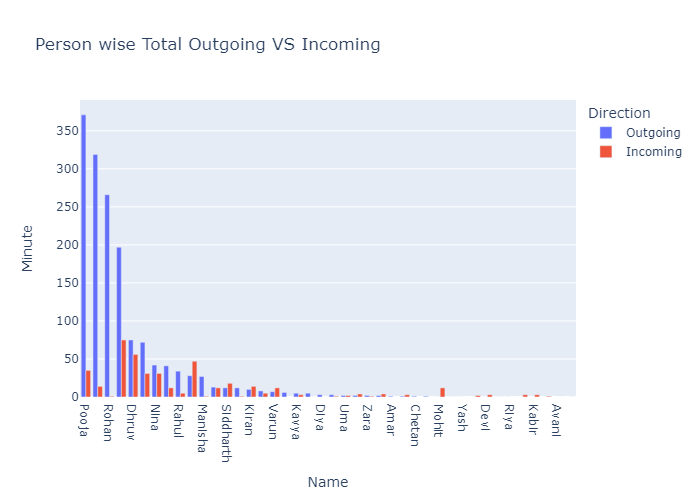

In [7]:
field_dict = {'Status': 'Answered'}
fil_df = multiple_field_filter(df, field_dict)

group_by = ['Name', 'Direction']
col_name = 'Minute'
title = 'Person wise Total Outgoing VS Incoming'

fig_attr = {'color': 'Direction', 'barmode': 'group'}

fig = generate_fig(fil_df, group_by, cal_total_min, col_name, title, fig_attr)
fig.show('png')

## Total Duration of Calls with Each Person

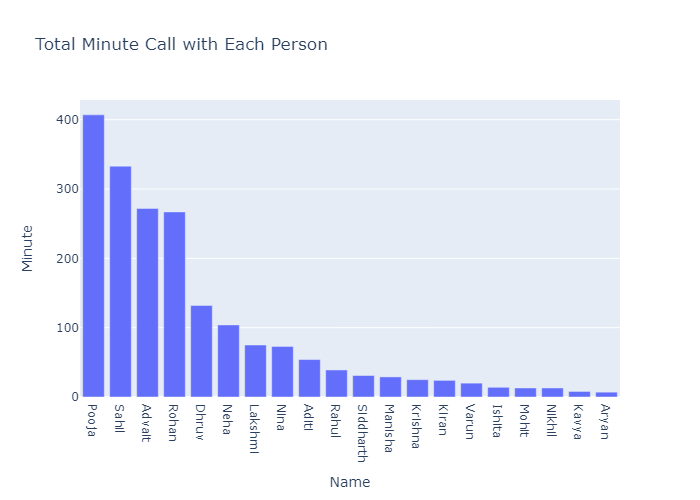

In [8]:
field_dict = {'Status': 'Answered'}
fil_df = multiple_field_filter(df, field_dict)

group_by = ['Name']
col_name = 'Minute'
title = 'Total Minute Call with Each Person'

top_k = 20
fig = generate_fig(fil_df,
                   group_by,
                   cal_total_min,
                   col_name,
                   title,
                   top_k=top_k)
fig.show('png')

## Average Talk-Time with Each Person

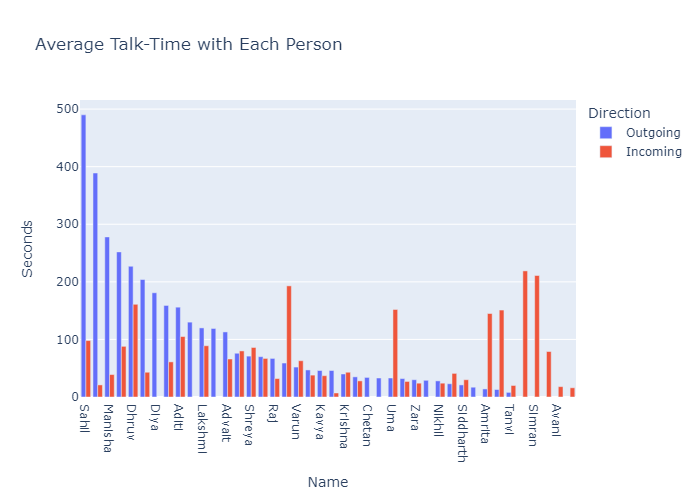

In [9]:
field_dict = {'Status': 'Answered', 'Contact': 'Saved'}
fil_df = multiple_field_filter(df, field_dict)

group_by = ['Name', 'Direction']
col_name = 'Seconds'
title = 'Average Talk-Time with Each Person'

fig_attr = {'color': 'Direction', 'barmode': 'group'}
fig = generate_fig(fil_df, group_by, average_total_sec, col_name, title,
                   fig_attr)
fig.show('png')

## Who gave me Most Missed Call

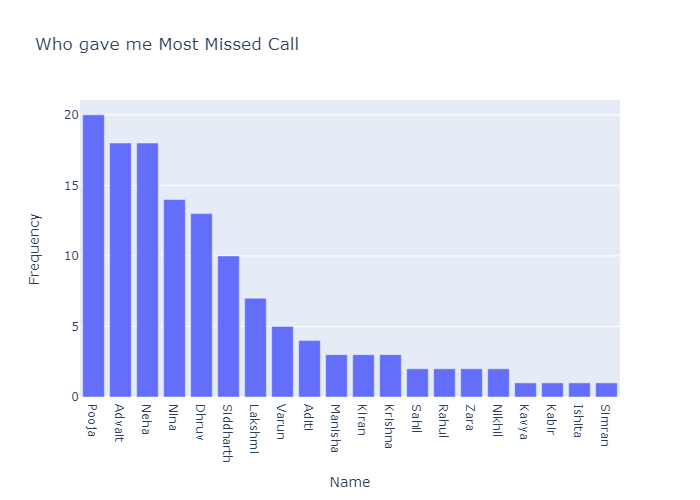

In [10]:
field_dict = {'Status': 'Missed', 'Contact': 'Saved'}
fil_df = multiple_field_filter(df, field_dict)

group_by = ['Name']
col_name = 'Frequency'
title = 'Who gave me Most Missed Call'

top_k = 20
fig = generate_fig(fil_df,
                   group_by,
                   frequency_count,
                   col_name,
                   title,
                   top_k=top_k)
fig.show('png')

## Rejected Call by Me

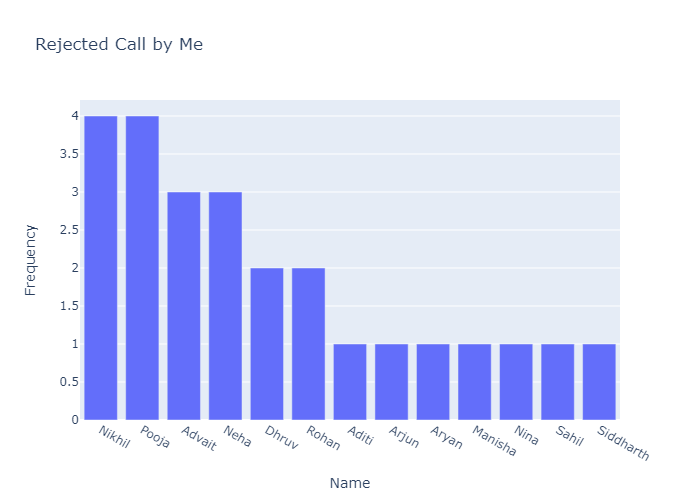

In [11]:
field_dict = {'Status': 'Call Rejected', 'Contact': 'Saved'}
fil_df = multiple_field_filter(df, field_dict)

group_by = ['Name']
col_name = 'Frequency'
title = 'Rejected Call by Me'

top_k = 20
fig = generate_fig(fil_df,
                   group_by,
                   frequency_count,
                   col_name,
                   title,
                   top_k=top_k)
fig.show('png')

## Rejected Call by Other

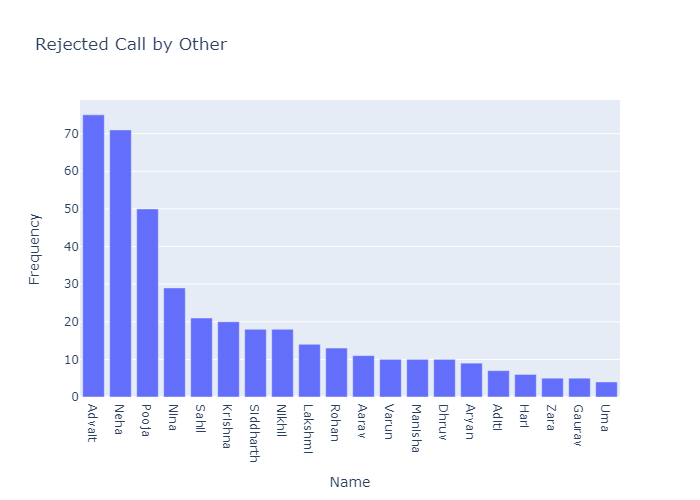

In [12]:
field_dict = {'Status': 'Unanswered', 'Contact': 'Saved'}
fil_df = multiple_field_filter(df, field_dict)

group_by = ['Name']
col_name = 'Frequency'
title = 'Rejected Call by Other'

top_k = 20
fig = generate_fig(fil_df,
                   group_by,
                   frequency_count,
                   col_name,
                   title,
                   top_k=top_k)
fig.show('png')

## My Call Schedule

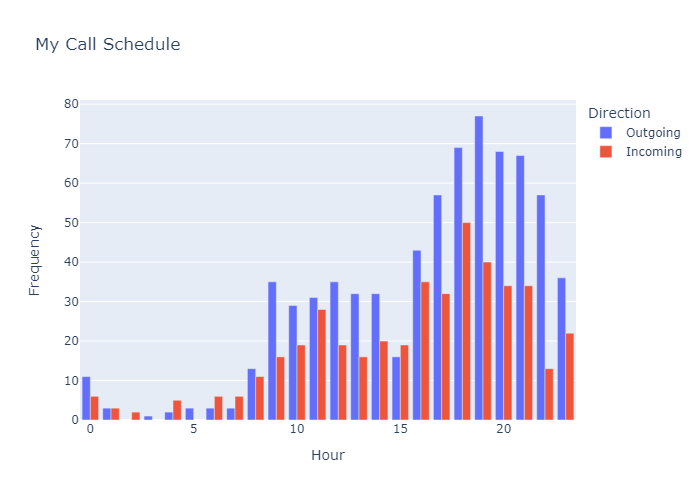

In [13]:
fig = call_time_fig(df)
fig.show('png')

## Person Wise Analysis

In [14]:
name = 'Aditi'
fig1, fig2 = person_wise_stats(df, name)

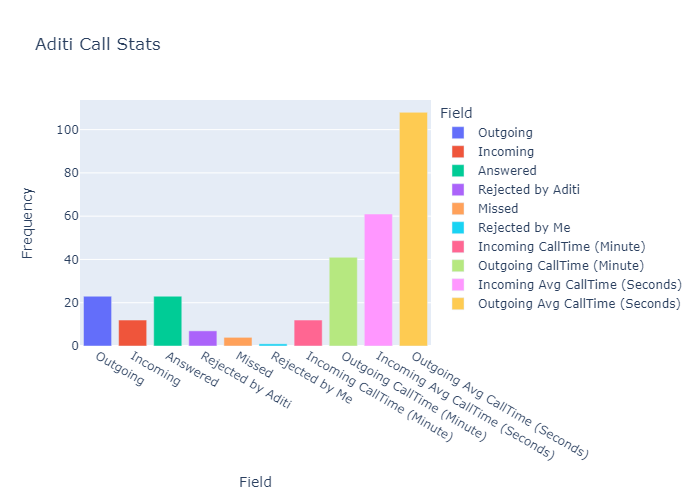

In [15]:
fig1.show('png')

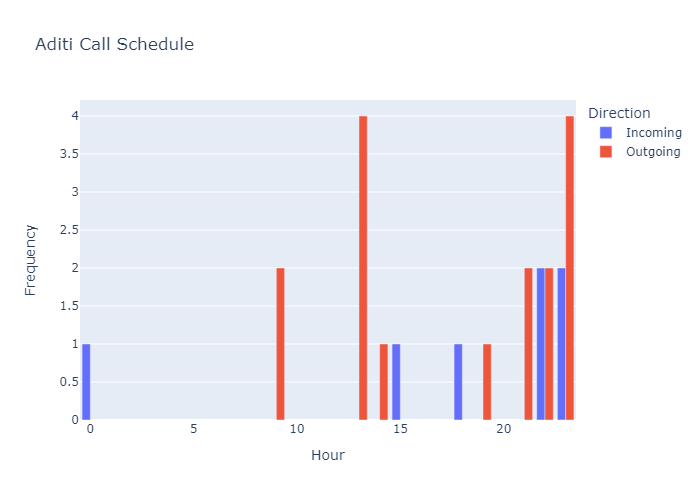

In [16]:
fig2.show('png')